## Imports

In [1]:


import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
transform = transforms.ToTensor()

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='../Notebook_files/data', train=True, download=True, transform=transform)
test_dataset=torchvision.datasets.CIFAR10(root='../Notebook_files/data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Notebook_files/data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Notebook_files/data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
torch.manual_seed(101)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [7]:
class_names = "plane car bird cat deer dog frog horse ship truck".split(" ")
class_names

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
for images, labels in train_dataloader:
    break

In [9]:
labels

tensor([1, 5, 8, 1, 6, 1, 6, 3, 7, 9])

Label: [1 5 8 1 6 1 6 3 7 9]
Class: car dog ship car frog car frog cat horse truck


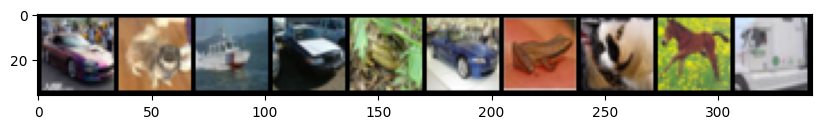

In [10]:
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=10)

plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

## MLP Model for the CIFAR 10 dataset

In [11]:
# class MLP(nn.Module):
#     def __init__(self):
#         super(MLP, self).__init__()
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(32*32*3, 512)  # First hidden layer
#         self.fc2 = nn.Linear(512, 256)      # Second hidden layer
#         self.fc3 = nn.Linear(256, 128)      # Third hidden layer
#         self.fc4 = nn.Linear(128, 10)       # Output layer

#     def forward(self, x):
#         x = self.flatten(x)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = self.fc4(x)
#         return x


## Changing the Width and Breadth of my MLP model

In [12]:
class ModifiedMLP(nn.Module):
    def __init__(self):
        super(ModifiedMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 1024)  # Increased width
        self.fc2 = nn.Linear(1024, 512)      # Adjusted to match new width of fc1
        self.fc3 = nn.Linear(512, 256)       # Existing layer
        self.fc4 = nn.Linear(256, 128)       # Existing layer
        self.fc5 = nn.Linear(128, 64)        # New layer (increased depth)
        self.fc6 = nn.Linear(64, 10)         # Output layer, adjusted to match new layer

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))   # New layer
        x = self.fc6(x)           # Adjusted to be the final layer
        return x

In [13]:
def train_model(num_of_runs=1, epochs=50, batch_size=16, learning_rate=0.0001):
    # Configuration parameters
    epochs = epochs
    batch_size = batch_size
    lr = learning_rate

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    all_train_losses, all_val_losses, all_accuracies = [], [], []

    for run_idx in range(1, num_of_runs + 1):
        # Loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Model, Loss, and Optimizer
        model = ModifiedMLP().to(device)
        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        train_losses, val_losses, accuracies = [], [], []

        for epoch in range(epochs):
            model.train()
            total_train_loss = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_func(outputs, labels)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item() * images.size(0)

            # Calculate average training loss for the epoch
            avg_train_loss = total_train_loss / len(train_loader.dataset)

            # Validation phase
            val_loss, accuracy = validate_model(model, val_loader, loss_func, device)
            
            train_losses.append(avg_train_loss)
            val_losses.append(val_loss)
            accuracies.append(accuracy)

            print(f"Epoch {epoch + 1}: Train Loss: {avg_train_loss:.3f}, Valid Loss: {val_loss:.3f}, Accuracy: {accuracy:.2f}")

        
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_accuracies.append(accuracies)
        
        # Save the model
        model_path = f'cifar10_model{run_idx}.pth'
        torch.save(model.state_dict(), model_path)

    print("Training complete.")
    return model, train_loader, val_loader, (all_train_losses, all_val_losses, all_accuracies)




def validate_model(model, val_loader, loss_func, device):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Calculate the loss
            loss = loss_func(outputs, labels)
            total_val_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    accuracy = correct_predictions / total_predictions

    return avg_val_loss, accuracy

In [14]:
def evaluate_and_plot_metrics(model, train_loader, val_loader, metrics):
    all_train_losses, all_val_losses, all_accuracies = metrics
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Calculate Precision, Recall, F1 Score, and Confusion Matrix using validation data
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Precision: {precision}\nRecall: {recall}\nF1 Score: {f1_score}")

    # Plotting
    plt.figure(figsize=(18, 7))

    # Plot training and validation loss
    plt.subplot(1, 3, 1)
    plt.plot(np.mean(all_train_losses, axis=0), label='Train Loss')
    plt.plot(np.mean(all_val_losses, axis=0), label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(np.mean(all_accuracies, axis=0), label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot confusion matrix
    plt.subplot(1, 3, 3)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.tight_layout()
    plt.show()

In [15]:
model, train_loader, val_loader, metrics = train_model()

Epoch 1: Train Loss: 1.936, Valid Loss: 1.817, Accuracy: 0.32
Epoch 2: Train Loss: 1.749, Valid Loss: 1.669, Accuracy: 0.40
Epoch 3: Train Loss: 1.650, Valid Loss: 1.644, Accuracy: 0.41
Epoch 4: Train Loss: 1.577, Valid Loss: 1.527, Accuracy: 0.46
Epoch 5: Train Loss: 1.520, Valid Loss: 1.508, Accuracy: 0.45
Epoch 6: Train Loss: 1.477, Valid Loss: 1.501, Accuracy: 0.46
Epoch 7: Train Loss: 1.434, Valid Loss: 1.502, Accuracy: 0.46
Epoch 8: Train Loss: 1.396, Valid Loss: 1.414, Accuracy: 0.50
Epoch 9: Train Loss: 1.356, Valid Loss: 1.436, Accuracy: 0.49
Epoch 10: Train Loss: 1.321, Valid Loss: 1.400, Accuracy: 0.51
Epoch 11: Train Loss: 1.289, Valid Loss: 1.382, Accuracy: 0.51
Epoch 12: Train Loss: 1.256, Valid Loss: 1.356, Accuracy: 0.53
Epoch 13: Train Loss: 1.226, Valid Loss: 1.387, Accuracy: 0.51
Epoch 14: Train Loss: 1.197, Valid Loss: 1.391, Accuracy: 0.51
Epoch 15: Train Loss: 1.169, Valid Loss: 1.332, Accuracy: 0.53
Epoch 16: Train Loss: 1.138, Valid Loss: 1.309, Accuracy: 0.54
E

Precision: 0.5474578775292949
Recall: 0.5393
F1 Score: 0.5407050208643057


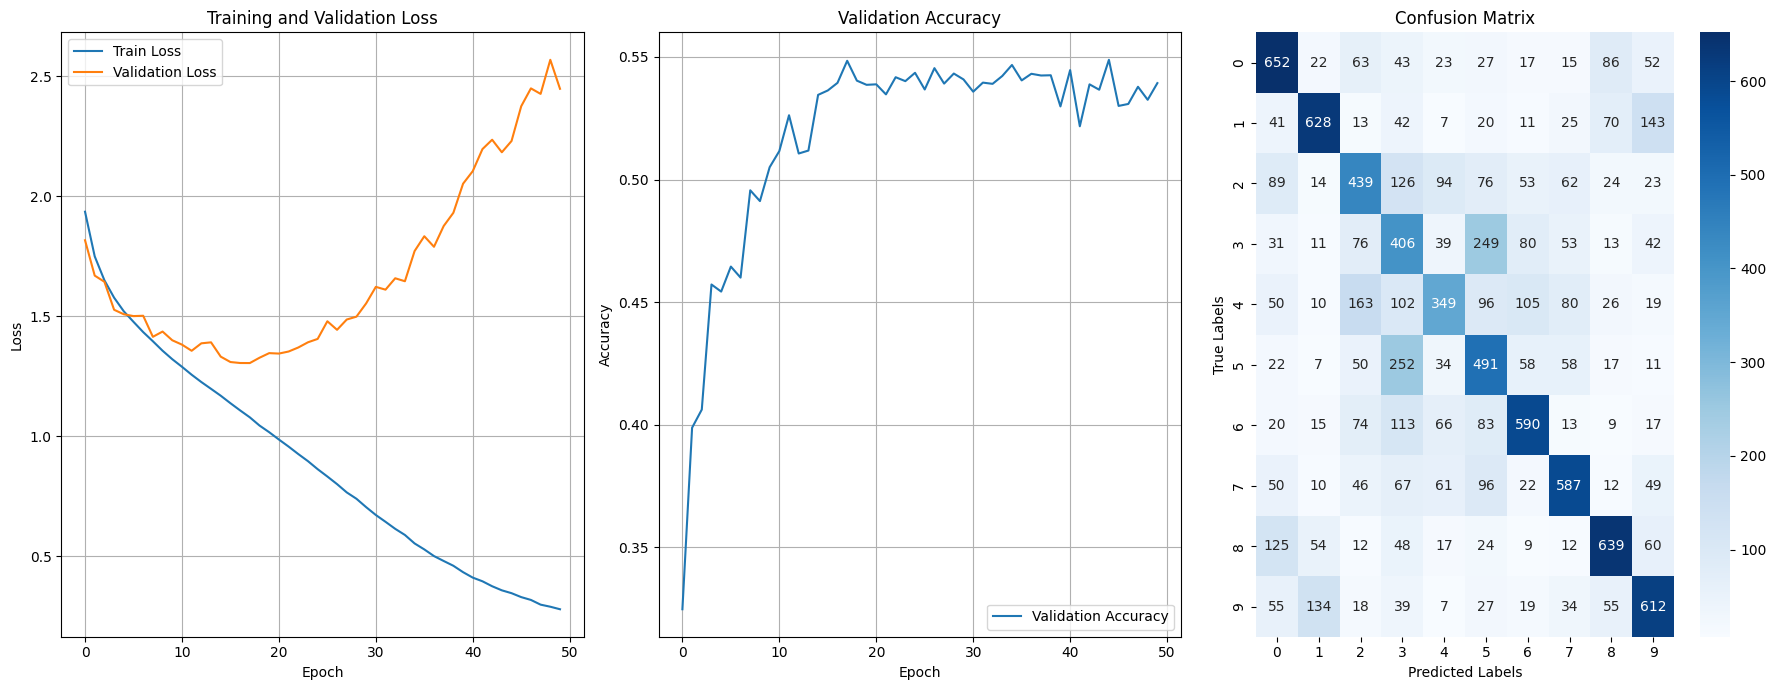

In [16]:
evaluate_and_plot_metrics(model, train_loader, val_loader, metrics)